In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:

pip install vaderSentiment 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [34]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

from pyspark.sql.functions import regexp_replace,year
from pyspark.sql.functions import col,count,when
from pyspark.sql import functions as F
#from pyspark.sql.functions import format_number as fmt
from pyspark.sql.functions import udf, split
from pyspark.sql.types import StringType, FloatType, IntegerType,BooleanType,ArrayType,DoubleType

from pyspark.ml.feature import Tokenizer,StopWordsRemover
#from pyspark.ml import PipelineModel
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import to_date
import re

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from pyspark.sql.window import Window

from pyspark.sql.functions import monotonically_increasing_id,row_number
sc =SparkContext.getOrCreate()

In [35]:
spark = SparkSession(sc)


Reading files

In [36]:
folder_path="/content/drive/MyDrive/coding_stocks/"

In [37]:
df1=spark.read.option("multiline", True).csv(folder_path+"Company_Tweet.csv",header=True)
df2=spark.read.option("multiline", True).csv(folder_path+"Company.csv",header=True)
df3=spark.read.option("multiline", True).csv(folder_path+"CompanyValues.csv",header=True)
df4=spark.read.option("multiline", True).csv(folder_path+"tweets.csv",header=True)

In [ ]:
# ### tweet id and corresponding ticker name

# df1.show(3)
# ### ticker symbol and company name

# df2.show(3)
# ## stock proce data for a comapny

# df3.show(3)
# ### information about tweets

# df4.show(3)

Data cleaning

In [103]:
# df2.show()

+-------------+------------+
|ticker_symbol|company_name|
+-------------+------------+
|         AAPL|       apple|
|         GOOG|  Google Inc|
|        GOOGL|  Google Inc|
|         AMZN|  Amazon.com|
|         TSLA|   Tesla Inc|
|         MSFT|   Microsoft|
+-------------+------------+



One problem is Googe Inc has two ticker_symbol, so we replace GOOG with GOOGL wherever required

In [104]:
# df1.printSchema()
# df2.printSchema()
# df3.printSchema()
# df4.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- ticker_symbol: string (nullable = true)

root
 |-- ticker_symbol: string (nullable = true)
 |-- company_name: string (nullable = true)

root
 |-- ticker_symbol: string (nullable = true)
 |-- day_date: string (nullable = true)
 |-- close_value: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- open_value: string (nullable = true)
 |-- high_value: string (nullable = true)
 |-- low_value: string (nullable = true)

root
 |-- _c0: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- post_date: string (nullable = true)
 |-- body: string (nullable = true)
 |-- comment_num: string (nullable = true)
 |-- retweet_num: string (nullable = true)
 |-- like_num: string (nullable = true)
 |-- date: string (nullable = true)



ticker_symbol is present in df1, df2, df3


In [38]:

df1=df1.withColumn('ticker_symbol', regexp_replace('ticker_symbol', 'GOOG$', 'GOOGL'))
df2=df2.withColumn('ticker_symbol', regexp_replace('ticker_symbol', 'GOOG$', 'GOOGL'))
df3=df3.withColumn('ticker_symbol', regexp_replace('ticker_symbol', 'GOOG$', 'GOOGL'))

In [39]:
cols=("_c0","post_date")
df4=df4.drop(*cols)
df4.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- body: string (nullable = true)
 |-- comment_num: string (nullable = true)
 |-- retweet_num: string (nullable = true)
 |-- like_num: string (nullable = true)
 |-- date: string (nullable = true)



convert into appropriate data types

In [40]:
df1=df1.withColumn("tweet_id",col("tweet_id").cast(DoubleType()))

df3=df3.withColumn("day_date",to_date(col("day_date")))
for c in df3.columns[2:]:
  df3=df3.withColumn(c,col(c).cast(FloatType()))

df4=df4.withColumn("date",to_date(col("date")))
df4=df4.withColumn("tweet_id",col("tweet_id").cast(DoubleType()))
for c in ["comment_num","like_num","retweet_num"]:
  df4=df4.withColumn(c,col(c).cast(IntegerType()))

In [41]:
# df1.show(4)

Checking for null values

In [42]:
# df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

In [43]:
# df2.select([count(when(col(c).isNull(), c)).alias(c) for c in df2.columns]).show()
# df3.select([count(when(col(c).isNull(), c)).alias(c) for c in df3.columns]).show()
# df4.select([count(when(col(c).isNull(), c)).alias(c) for c in df4.columns]).show()

In [44]:
df4=df4.na.drop(subset=["tweet_id","body","date"])
df4.show(2)
#df4.select([count(when(col(c).isNull(), c)).alias(c) for c in df4.columns]).show()

+--------------------+---------------+--------------------+-----------+-----------+--------+----------+
|            tweet_id|         writer|                body|comment_num|retweet_num|like_num|      date|
+--------------------+---------------+--------------------+-----------+-----------+--------+----------+
|5.504415091754434...|VisualStockRSRC|lx21 made $10,008...|          0|          0|       1|2015-01-01|
|5.504416723125125...|    KeralaGuy77|Insanity of today...|          0|          0|       0|2015-01-01|
+--------------------+---------------+--------------------+-----------+-----------+--------+----------+
only showing top 2 rows



In [45]:
#**text cleaning**


def cleantext(tweet):
    '''
    cleantext takes input a tweet and clean it of special characters, 
    hashtags, handles, and multiple spaces
    '''
    ## removing url
    url=r"https?:\/\/\S+"
    tweet=re.sub("[()]"," ",tweet)
    r1=re.findall(url,tweet)
 
    for i in r1:
        tweet=re.sub(i,'', tweet)

    ## removing all the hashtags
    hashtag=r"#[a-zA-Z0-9]+"
    r2=re.findall(hashtag,tweet)
    print(r2)
    for i in r2:
      tweet=re.sub(i," ", tweet)  

    ## removing handles  
    handle="@[a-zA-Z]+"
    r3=re.findall(handle, tweet)
    print(r3)
    for i in r3:
        tweet=re.sub(i,' ',tweet)

    ## removing special words expcept !    
    tweet=re.sub(r"[^a-zA-Z!]"," ",tweet)   
    tweet+=" "

    tweet=re.sub(r" +", " ",tweet)
    return tweet


udfrp=udf(cleantext,StringType())

In [46]:
dftweet=df4.withColumn('body_cleaned',udfrp('body'))

In [47]:

#### Tokenization and stop word removal###
tokenizer = Tokenizer(inputCol='body_cleaned', outputCol='tokens')
stopwords=StopWordsRemover(inputCol='tokens', outputCol='tokens_cleaned')

dftweet = tokenizer.transform(dftweet)
dftweet= stopwords.transform(dftweet)

def jointext(words):
    return ' '.join(words)

udfjoin=udf(jointext,StringType())
dftweet=dftweet.withColumn('reduced_text',udfjoin("tokens_cleaned"))



**Calculating Results for sentiment analysis using VADER**

In [49]:

def vdscore(tweet):
  '''
  returns compound score
  '''

  sia = SentimentIntensityAnalyzer()
  scores = sia.polarity_scores(tweet)
  return (float(scores["compound"]))
def vdscoreneg(tweet):
    '''
  returns negative score
  '''
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(tweet)
    return (float(scores["neg"]))
def vdscorepos(tweet):
    '''
  returns positive score
  '''
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(tweet)
    return (float(scores["pos"]))
def vdscoreneu(tweet):
    '''
  returns neutral score
  '''
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(tweet)
    return (float(scores["neu"]))



In [50]:
udfvs = udf(vdscore,FloatType())
udfvsneg = udf(vdscoreneg,FloatType())
udfvsneu = udf(vdscoreneu,FloatType())
udfvspos = udf(vdscorepos,FloatType())

### Adding results to the dataframe
dftweet=dftweet.withColumn("scores", udfvs("reduced_text"))
dftweet=dftweet.withColumn("neg",udfvsneg("reduced_text"))
dftweet=dftweet.withColumn("pos",udfvspos("reduced_text"))
dftweet=dftweet.withColumn("neu",udfvsneu("reduced_text"))



In [53]:
df=dftweet.select("tweet_id","date","scores","neg","pos","neu")
#df.show(4)

EDA

In [55]:
df.head()

Row(tweet_id=5.5044150917544346e+17, date=datetime.date(2015, 1, 1), scores=0.7777000069618225, neg=0.0, pos=0.3269999921321869, neu=0.6729999780654907)

In [54]:
df.printSchema()

root
 |-- tweet_id: double (nullable = true)
 |-- date: date (nullable = true)
 |-- scores: float (nullable = true)
 |-- neg: float (nullable = true)
 |-- pos: float (nullable = true)
 |-- neu: float (nullable = true)



In [57]:
dftweet=df1.join(df, on="tweet_id",how="right")

In [58]:
dftweet.show(3)

+--------------------+-------------+----------+-------+-----+-----+-----+
|            tweet_id|ticker_symbol|      date| scores|  neg|  pos|  neu|
+--------------------+-------------+----------+-------+-----+-----+-----+
|5.504416723125125...|         AAPL|2015-01-01|-0.8271|0.442|  0.0|0.558|
|5.504429778022072...|         TSLA|2015-01-01|    0.0|  0.0|  0.0|  1.0|
|5.504415091754434...|         AAPL|2015-01-01| 0.7777|  0.0|0.327|0.673|
+--------------------+-------------+----------+-------+-----+-----+-----+
only showing top 3 rows



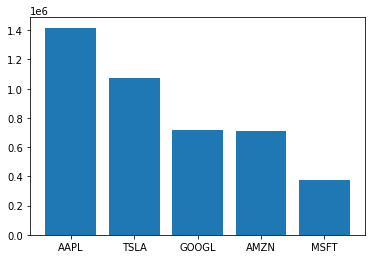

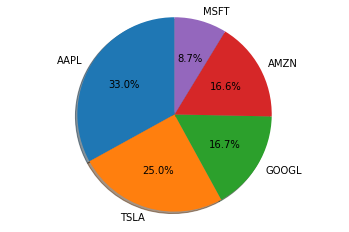

In [59]:
# tweetcount=dftweet.groupby('ticker_symbol').count().select('ticker_symbol','count').rdd.map(
#   lambda x: (x[0],x[1])).collect()
# print(tweetcount)
# keys=[i[0] for i in tweetcount]
# values=[i[1] for i in tweetcount]
# plt.bar(keys,values)
# plt.show()
# fig1, ax1 = plt.subplots()
# ax1.pie(values,  labels=keys, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

In [67]:
tweet_results=dftweet.toPandas()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
tweet_results

In [66]:
average=dftweet.groupBy("ticker_symbol","date").agg(avg("scores"))

In [61]:
from pyspark.sql.functions import sum,avg,max

In [65]:
average.show(4)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:

group_cols = ["department", "state"]
df.groupBy(group_cols) \
    .agg(sum("salary").alias("sum_salary"), \
         avg("salary").alias("avg_salary"), \
         sum("bonus").alias("sum_bonus"), \
         max("bonus").alias("max_bonus") \
     ) \
    .show(truncate=False)

In [72]:
# 


# dftweet.show(5)
# df1.count()
# dftweet.count()

# Date range for which tweets are available
# ### checking the date range

# col_earlist_date = F.min('date').alias('earliest')
# col_latest_date = F.max('date').alias('latest')
# df_result = dftweet.select(col_earlist_date, col_latest_date)
# df_result.show()
# Earliest date is absurd, on checking closely, this should be removed. seems like an error
# dftweet.orderBy("date",ascending=True).show(5)
# dftweet=dftweet.filter(year('date')>2014)
# dftweet.orderBy("date",ascending=True).show(5)
# dftweet.count()
